In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from pymatgen.ext.matproj import MPRester
from scipy.optimize import minimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import pandas
from ase import io
import os
from pymatgen.io.ase import AseAtomsAdaptor

Need to pickle in the data we've gathered from mp


In [2]:
unary_data = pickle.load(open("../data_gather/unary_oxide_data.p", "rb"))
binary_oxide_data = pickle.load(open("../data_gather/binary_oxide_data.p", "rb"))

In [3]:
def get_ref_data_oqmd(element, reference_oxide_id):
    for idx, id_ in enumerate(oqmd_info['filename']):
        #id_ = id_.split("_")[]
        #print(id_)
        if reference_oxide_id in id_:
            #print(reference_oxide_id)
            #print(id_)
            #ref_fingerprint = unary_data[element]['fingerprints'][idx]
            ref_struct = oqmd_structs[reference_oxide_id]
            ref_form_ene = oqmd_info[' _oqmd_delta_e'][idx]
            #print(ref_form_ene)
            print("Reference oxide formation energy: {:.3f} eV".format(ref_form_ene))
            return ref_form_ene#, ref_fingerprint
        
def get_lower_hull_oqmd(low_ox_state_data, oxidation_state, ref_form_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram.
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    if oxidising:
        for ox in low_ox_state_data:
             if ox<=8 and oxidation_state==4:
                pairs.append((ox-oxidation_state,low_ox_state_data[ox]-ref_form_ene ))

        if len(pairs)==2:
            # need to add oxygen end member data
            pairs.append((oxidation_state, -ref_form_ene))
        pairs = np.array(pairs)
        try:
            hull = ConvexHull(pairs)
        except Exception as e:
            print(e)
            print("{} needs to be done differently.".format(reference_element_))
            return None
    else:
        for ox in low_ox_state_data:
            pairs.append((oxidation_state-ox,low_ox_state_data[ox]-ref_form_ene ))
        if reference_element_=='Ni' or reference_element_=='Co' and oxidation_state==4:
            pairs.append((4, 0))
        pairs = np.array(pairs)

        try:
            hull = ConvexHull(pairs)
        except Exception as e:
            print(e)
            print(" needs to be done differently.".format(reference_element_))
            return None
    resultant_hull = get_lower_hull_points(hull, pairs)
    return resultant_hull


def get_ox2lowest_oqmd(reference_element_, ref_id, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    """
    ref_form_ene = get_ref_data_oqmd(reference_element_, ref_id)
    struct_differences = []
    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)

    for idx, oqmd_id in enumerate(oqmd_ids):
        #struct_difference = np.linalg.norm(ref_fingerprint_ - unary_data[reference_element_]['fingerprints'][idx])
        m_coordinations, ox_state, o_o_coords, _, _ = structure_inspection(oqmd_structs[oqmd_id])
        #print(list(m_coordinations))
        #mpid = unary_data[reference_element_]['mp_ids'][idx]
        #oqmd_enes[]
        #mp_ids.append(mpid)
        #print(list(m_coordinations),oqmd_enes[oqmd_id],ox_state)

        if oxidising:
            bool2check = ox_state>4
        else:
            bool2check = ox_state<4
        #if bool2check and 4.3<np.mean(m_coordinations)<6.1:
        if bool2check and list(set(m_coordinations))==[6]:
            #struct_differences.append(struct_difference)
            #query = mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom', 'e_above_hull'])
            formation_energy = oqmd_enes[oqmd_id]
            #e_above_hull = query.data['e_above_hull']
            ox2data[ox_state].append(formation_energy)
            #print(ox2lowest)
            #print(oqmd_id, formation_energy, ox_state, np.mean(m_coordinations))
            #print(ox2lowest[ox_state])
            if ox_state not in ox2lowest.keys():# and e_above_hull<1:
                ox2lowest[ox_state] = formation_energy#, 0)#, struct_difference)

            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state]:
                ox2lowest[ox_state] = formation_energy#, 0)#, struct_difference)
    print(ox2lowest)
    return ox2lowest


def get_entry_by_spacegroup(oqmd_properties, spacegroup):
    """
    Returns the relevant ID which finds the matching oxide for a given stoichiometry,
    eg. P42/mnm for rutile
    """
    matching_rows = set()
    for row in oqmd_properties.values:
        #print(row)
        if spacegroup in row:
            #print(row)
            matching_rows.add(row[0])
    return matching_rows

In [4]:
def get_ref_data(element, reference_oxide_id):
    for idx, id_ in enumerate(unary_data[element]['mp_ids']):
        if id_==reference_oxide_id:
            ref_fingerprint = unary_data[element]['fingerprints'][idx]
            ref_struct = unary_data[element]['structures'][idx]
            ref_ene = unary_data[element]['energies'][idx]
            ref_form_ene = unary_data[element]['formation_energies'][idx]
            #print("Reference oxide formation energy: {:.3f} eV".format(ref_form_ene))
            return ref_form_ene, ref_fingerprint, ref_struct


def uncorr_ene_from_formation_energy(formation_energy_correction, ele1, ele2, ele1_conc, o_conc):
    """
    Return the synthetically calculated uncorrected DFT energy given a formation energy correction with
    respect to the reference oxides.
    """
    o_energy = -4.948
    o_correction = -0.687
    ele1_ene, ele1_fingerprint, ele1_struct = get_ref_data(ele1, ele2mp[ele1])
    ele2_ene, ele2_fingerprint, ele2_struct = get_ref_data(ele2, ele2mp[ele2])
    
    total_form_ene = ele1_ene*ele1_conc+ele2_ene*(1-ele1_conc)+formation_energy_correction
    end_member_ene = (1-o_conc)*(ele1_conc*ele2gs[ele1]+(1-ele1_conc)*ele2gs[ele2])+(o_conc)*(o_energy)
    corrections = o_conc*(o_correction)
    # now get the corrections that would be applied per atom
    if ele1 in u_correction.keys():
        corrections += (1-o_conc)*(ele1_conc*u_correction[ele1])
    if ele2 in u_correction.keys():
        corrections += (1-o_conc)*((1-ele1_conc)*u_correction[ele2])
    # by definition formation energy = (mixed system energy) - (end member energy), here we just manipulate
    # that equation and remove the MP corrections.
    uncorr_energy = total_form_ene+end_member_ene
    return uncorr_energy 


def make_synthetic_mp(energy_correction, ele1, ele2, ele1_conc, o_conc):
    name = "{}{}{}{}O{}".format(ele1, (1-o_conc)*(ele1_conc), ele2, (1-o_conc)*(1-ele1_conc), o_conc)
    composition = Composition(name)
    label = "{}{:.3f}{}{:.3f}O{:.3f}".format(ele1, (1-o_conc)*(ele1_conc), ele2, (1-o_conc)*(1-ele1_conc), o_conc)
    energy = uncorr_ene_from_formation_energy(energy_correction, ele1, ele2, ele1_conc, o_conc)
    return PDEntry(composition, energy, name=name), label


def get_hull_energy(min_mu_o, max_mu_o, entries):
    list_mu_Os = np.linspace(min_mu_o, max_mu_o, 10)
    data = []
    hull = []
    for mu_Os in list_mu_Os:
        open_elements_specific = {Element("O"):mu_Os}
        gcpd = GrandPotentialPhaseDiagram(entries, open_elements_specific)
        l = [gcpd.get_form_energy_per_atom(e) for e in gcpd.all_entries]
        h = [gcpd.get_e_above_hull(e) for e in gcpd.all_entries]
        data.append(l)
        hull.append(h)
    hull = np.array(hull)
    data = np.array(data)
    return hull, data, gcpd, list_mu_Os

def load_data(ele1, ele2):
    entries = []
    labels = []
    entries_1 = mpr.get_entries('{}-{}-O'.format(ele1, ele2))+mpr.get_entries('{}-O'.format(ele1))+mpr.get_entries('{}-O'.format(ele2))
    for entry in entries_1:
        if 'H' in entry.name:
            continue
        entries.append(entry)
        labels.append(entry.name)
    return entries, labels


def structure_inspection(structure):
    """
    Need to know the coordination in a given oxide, the 2.5 Å cutoff could be tuned per element
    """
    num_o_sites = 0 
    m_coordinations = []
    o_o_coordinations = []
    o_m_coordinations = []
    for site in structure.sites:
        if str(site.specie)=='O':
            num_o_sites += 1
            nn_info = structure.get_neighbors(site, 2.5)
            o_coord = 0
            o_m_coord = 0
            for nn in nn_info:
                #print(str(nn.specie))
                if str(nn.specie)=="O":
                    o_coord+=1
                else:
                    o_m_coord+=1
                #assert str(nn.specie)=='O'
            o_o_coordinations.append(o_coord)
            o_m_coordinations.append(o_m_coord)
        else:
            # check nearest neighbours for coordination
            nn_info = structure.get_neighbors(site, 2.5)
            m_coord = 0
            for nn in nn_info:
                #print(str(nn.specie))
                if str(nn.specie)=="O":
                    m_coord+=1
                #assert str(nn.specie)=='O'
            m_coordinations.append(m_coord)
    o_percent = num_o_sites/len(structure.sites)
    ox_state = round((o_percent*2/(1-o_percent)), 3)
    return m_coordinations, ox_state, o_o_coordinations, o_m_coordinations, round(o_percent, 3)


def plot_coords(reference_element_):
    struct_differences = []
    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        query = mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom',])
        formation_energy = query.data['formation_energy_per_atom']
        if set(list(m_coordinations))=={6}:
            plt.plot(ox_state, formation_energy, 'bo', alpha=0.1)
        elif set(list(m_coordinations))=={4}:
            plt.plot(ox_state, formation_energy, 'ro', alpha=0.9)
            #print(mpid)
        elif set(sorted(list(m_coordinations)))=={5}:
            plt.plot(ox_state, formation_energy, 'go', alpha=0.9)
        #else:
        #    plt.plot(ox_state, formation_energy, 'yo', alpha=0.7)

    plt.show()

def get_conc_in_binary(structure, element):
    element_count = 0
    other_element_count = 0
    for site in structure.sites:
        if str(site.specie)==element:
            element_count+=1
        elif str(site.specie)=='O':
            continue
        else:
            other_element_count+=1
    return element_count/(element_count+other_element_count)


def get_quadratic(lower_hull_data, max_x=4):
    """
    Iterate over the hull dictionary to get x and y to fit 2nd order polynomial through those points
    """
    xs = []
    ys = []
    for ox in lower_hull_data:
        xs.append(ox)
        ys.append(lower_hull_data[ox])
        
    coeffs_ = np.polyfit(xs, ys, 2)
    x = np.linspace(0, max_x, 100)
    y = coeffs_[0]*x**2 + coeffs_[1]*x + coeffs_[2]
    plt.plot(x, y)
    plt.show()
    return coeffs_


def check_if_upper(upper_hull_points, hull_simplex):
    """
    Helper function so that for loop in get_lower_hull_points function can be skipped when
    we see a point that is on the upper half of the hull.
    """
    for index in upper_hull_points:
        if index in hull_simplex:
            return True
    return False
    
def get_lower_hull_points(hull_, pairs_, plotting=True):
    """
    Function to remove points on the upper half of the hull, these are unstable and ignored,  
    to handle the fact that scipy gets the entire hull not just the low energy points we want.
    Args: 
    hull_: Returned value from scipy's ConvexHull, where the x-axis is oxidation state and the
    y-axis is formation energy.
    pairs_: The values themselves, pairs_[i, 0] gives the ith oxidation state
    pairs_[i, 1] the ith formation energy.
    plotting: Whether to plot the points to be fitted through
    """
    points_on_upper_hull = set()
    for vertex_index, vertex in enumerate(hull_.vertices):
        # check if on upper or lower half of hull
        for simplex in hull_.simplices:
            low_ox = min(pairs_[simplex, 0])
            low_ox_ene = pairs_[simplex, 1][np.argmin(pairs_[simplex, 0])]
            high_ox = max(pairs_[simplex, 0])
            high_ox_ene = pairs_[simplex, 1][np.argmax(pairs_[simplex, 0])]
            difference = high_ox - low_ox
            vertex_ox = pairs_[vertex, 0]
            vertex_diff = vertex_ox-low_ox

            difference_ratio = vertex_diff/difference
            value_on_hull = high_ox_ene*(1-difference_ratio)+low_ox_ene*(difference_ratio)
            if low_ox<pairs_[vertex,0]<high_ox and value_on_hull<pairs_[vertex,1]:
                # if this is true it means the oxidation state is between two other oxidation states on the hull,
                # and lies above the weighted average on the line connecting those oxidation states
                points_on_upper_hull.add(hull_.vertices[vertex_index])
        
    hullox2ene = defaultdict()
    for simplex in hull_.simplices:
        if check_if_upper(points_on_upper_hull, simplex):
            continue
        hullox2ene[pairs_[simplex, 0][0]] = pairs_[simplex, 1][0]
        hullox2ene[pairs_[simplex, 0][1]] = pairs_[simplex, 1][1] 
        if plotting:
            plt.plot(pairs_[simplex, 0], pairs_[simplex, 1], 'k--')
            plt.plot(pairs_[simplex, 0][0], pairs_[simplex, 1][0], 'ro')
            plt.plot(pairs_[simplex, 0][1], pairs_[simplex, 1][1], 'ro')

    return hullox2ene

def get_lower_hull(low_ox_state_data, ref_oxidation_state, ref_formation_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram.
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    ref_formation_ene: Formation energy in eV/atom of refernece state.
    ref_oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    if oxidising:
        for ox in low_ox_state_data:
            #print(ox)
            #if ox<=8:
            if reference_element_=='W' and ox_state%1!=1:
                # need to fit through WO3
                pairs.append((ox-ref_oxidation_state,low_ox_state_data[ox][0]-ref_formation_ene ))
            else:
                pairs.append((ox-ref_oxidation_state,low_ox_state_data[ox][0]-ref_formation_ene ))
        if len(pairs)==2:
            # need to add oxygen end member data
            print("WARNING! Adding an end member so can perform fit, try gather more data for this element.")
            pairs.append((ref_oxidation_state, -ref_formation_ene))
        pairs = np.array(pairs)
        try:
            hull = ConvexHull(pairs)
        except Exception as e:
            print(e)
            print("{} needs to be done differently.".format(reference_element_))
            return None
    else:
        for ox in low_ox_state_data:
            print(ox)
            if reference_element_=='Ni' and 2.5<ox<3:
                continue
            pairs.append((ref_oxidation_state-ox,low_ox_state_data[ox][0]-ref_formation_ene ))
        if reference_element_=='Ni' or reference_element_=='Co' and ref_oxidation_state==4:
            pairs.append((4, 0.))
    if len(pairs)==2:
        # need to add oxygen end member data
        print("WARNING! Adding an end member so can perform fit, try gather more data for this element.")
        pairs.append((ref_oxidation_state, -ref_formation_ene))
    pairs = np.array(pairs)

    try:
        hull = ConvexHull(pairs)
    except Exception as e:
        print(e)
        print("{}  needs to be done differently.".format(reference_element_))
        return None
    resultant_hull = get_lower_hull_points(hull, pairs)
    return resultant_hull


def get_ox2lowest(reference_element_, reference_mpid, ref_oxidation_state, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    Args:
    reference_element_: The element to iterate over, passed as a string
    reference_mpid: The mp-id being taken as a reference, passed as string
    ref_oxidation_state: The reference oxidation state, passed as an int.
    oxidising: Whether we want the dictionary of the oxidation state to formation energies with 
    oxidation states higher (oxidising=True) or lower (oxidising=False) than ref_oxidation_state
    """
    ref_form_ene, ref_fingerprint_, ref_structure_ = get_ref_data(reference_element_, reference_mpid)
    ref_m_coords, ref_ox_state, ref_o_o_coords, ref_o_m_coords, ref_o_pc = structure_inspection(ref_structure_)
    assert ref_ox_state==ref_oxidation_state
    struct_differences = []
    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        struct_difference = np.linalg.norm(ref_fingerprint_ - unary_data[reference_element_]['fingerprints'][idx])
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)

        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        if oxidising:
            bool2check = ox_state>ref_oxidation_state
        else:
            bool2check = ox_state<ref_oxidation_state
        # this determines whether to save the entry based on coordinations, if your reference is different
        if bool2check and set(list(m_coordinations))=={6}:#set(list(ref_m_coords)):
        #if bool2check and 4.5<np.mean(m_coordinations)<6:#set(list(ref_m_coords)):
            struct_differences.append(struct_difference)
            #query = unary_data[reference_element_]['fingerprints'][idx]#mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom', 'e_above_hull'])
            formation_energy = unary_data[reference_element_]['formation_energies'][idx]
            #e_above_hull = query.data['e_above_hull']
            ox2data[ox_state].append(formation_energy)
           # print(np.mean(o_m_coords))
            #print(unary_data[reference_element_]['names'][idx], unary_data[reference_element_]['mp_ids'][idx])

            if ox_state not in ox2lowest.keys():# and e_above_hull<1:
                ox2lowest[ox_state] = (formation_energy, struct_difference)
            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state][0]:
                ox2lowest[ox_state] = (formation_energy, struct_difference)
    return ox2lowest, ref_form_ene


def get_ox2lowest_no_reference(reference_element_):
    """
    Returns a dictionary for a given element with keys for oxygen concentration and 
    values for the lowest formation energy at that concentration from 0 to 1.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    conc2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        
        #query = unary_data[reference_element_]['fingerprints'][idx]#mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom', 'e_above_hull'])
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]

        if o_pc not in conc2lowest.keys():
            conc2lowest[o_pc] = formation_energy
        elif o_pc in conc2lowest.keys() and formation_energy<conc2lowest[o_pc]:
            conc2lowest[o_pc] = formation_energy
    return conc2lowest


def get_binary_mp_data(element1, element2):
    pairings = []
    found_key = False
    for key in binary_oxide_data.keys():
        if element1 in key and element2 in key:
            # the order of the elements is arbitrary, depends how the data was gathered
            needed_key = key
            found_key = True
    if not found_key:
        print("No data for combination: {}, {}".format(element1, element2))
        return 
    
    conc2lowest = defaultdict()
    lowest_ene = 0 
    for idx, struct in enumerate(binary_oxide_data[needed_key]['structures']):
        m_coords, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        if ox_state==4 and list(set(m_coords))==[6]:
            # then we care about this structure to make comparisons
            dope_conc = get_conc_in_binary(struct, element2)
            #print(dope_conc)
            #print(binary_oxide_data['{}_Sb'.format(dope_element)]['names'][idx])
            mixed_energy = binary_oxide_data[needed_key]['formation_energies'][idx]
            dope_o2_ene, dope_o2_fingerprint, dope_o2_struct = get_ref_data(element2, ele2mp[element2])
            sbo2_ene, sbo2_fingerprint, sbo2_struct = get_ref_data(element1, ele2mp[element1])
            binary_fingerprint = np.array(ssf.featurize(struct))
            ##if element2=='Ni':
             #   dope_o2_ene+=0.05
            diff_sbo2 = np.linalg.norm(binary_fingerprint-sbo2_fingerprint)
            diff_eleo2 = np.linalg.norm(binary_fingerprint-dope_o2_fingerprint)
            mixing_stabilisation = mixed_energy - (dope_o2_ene*dope_conc+(sbo2_ene)*(1-dope_conc))
            pairings.append((dope_conc, mixing_stabilisation, element2))
            gs_key = element2+"_{:.2f}".format(dope_conc)
            if gs_key not in conc2lowest:
                conc2lowest[element2+"_{:.2f}".format(dope_conc)] = (dope_conc, mixing_stabilisation)
            elif conc2lowest[gs_key][1]>mixing_stabilisation:
                conc2lowest[element2+"_{:.2f}".format(dope_conc)] = (dope_conc, mixing_stabilisation)
    return pairings, conc2lowest


def formation_energy_mixing(ox_quadratic_1, red_quadratic_1, ox_quadratic_2, red_quadratic_2, concentrations):
    pairings = []
    ground_states =  []

    #concs = np.arange(0.0000001, 0.9999999, conc_interval)
    predicted_forms_1 = []
    predicted_forms_2 = []
    predicted_ox_change_1 = []
    predicted_ox_change_2 = []
    concs =[]
    synthetic_entries = []
    for conc in concentrations:
        o_1a, o_2a, o_3a = ox_quadratic_1
        r_1a, r_2a, r_3a = red_quadratic_1

        o_1b, o_2b, o_3b = ox_quadratic_2
        r_1b, r_2b, r_3b = red_quadratic_2

        result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, o_3a, r_1a, r_2a, r_3a),  bounds=[(0, 3)])
        # Note, the definition of concentration is different  between 1/2, handle this when plotting 
        # by flipping the x-axis horizontally
        result_2 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1b, o_2b, o_3b, r_1b, r_2b, r_3b),  bounds=[(0, 3)])

        predicted_ox_change_1.append(result_1.x[0])
        predicted_forms_1.append(result_1.fun[0])

        predicted_ox_change_2.append(result_2.x[0])
        predicted_forms_2.append(result_2.fun[0])
        concs.append(conc)
        
    xs_1 = []
    xs_2 = []
    for conc in concs:
        # need to shift the energies so that either end is set to 0
        # so shift every point proportionally
        xs_1.append(predicted_forms_1[0]*(1-conc)+predicted_forms_1[-1]*conc)
        xs_2.append(predicted_forms_2[0]*(1-conc)+predicted_forms_2[-1]*conc)
    
    return np.array(predicted_forms_1)-xs_1, np.array(predicted_forms_2)-xs_2, predicted_ox_change_1, predicted_ox_change_2

        

def oxidation_reduction_equation(x, ox_conc, o1, o2, o3, r1, r2, r3):
    """
    Defines the equation to optimize oxidation state when mixed
    Args:
    x: The amount of oxidation state change
    ox_conc: The concentration of the oxidising element between 0 and 1
    o1, o2, o3: Define the quadratic equation for the oxidising element
    r1, r2, r3: Define the quadratic equation for the reducing element
    """
    return (o1*x**2+o2*x+o3)+(r1*(ox_conc*x/(1-ox_conc))**2+r2*(ox_conc*x/(1-ox_conc))+r3)



Ge
Reference oxide formation energy: -1.889 eV
Reference oxide formation energy: -1.889 eV
{6.0: -1.1684, 7.0: -0.8604}


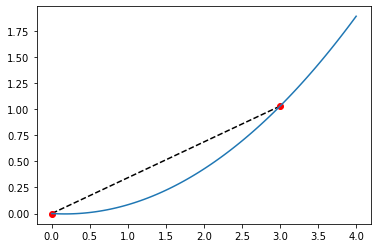

[ 1.29391667e-01 -4.53416667e-02 -8.01234453e-17]
Reference oxide formation energy: -1.889 eV
{2.0: -0.8549, 3.0: -1.2831}


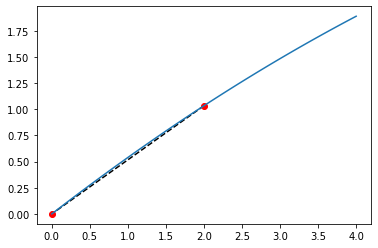

[-2.23875000e-02  5.61775000e-01 -6.40987562e-16]
Se
Reference oxide formation energy: -0.593 eV
Reference oxide formation energy: -0.593 eV
{6.0: -0.4493}


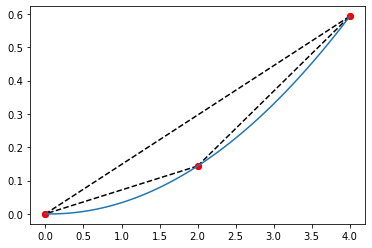

[ 3.82125000e-02 -4.62500000e-03  1.40216029e-17]
Reference oxide formation energy: -0.593 eV
{2.0: 0.294}
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 564061121  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

 needs to be done differently.
not much info ...
Ti
Reference oxide formation energy: -3.216 eV
Reference oxide formation energy: -3.216 eV
{5.5: -2.3594, 4.8: -2.4729, 6.0: -2.0049, 8.0: -1.4629, 5.0: -2.643}


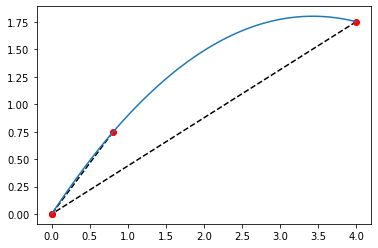

[-1.53250000e-01  1.05122500e+00  2.56395025e-16]
Reference oxide formation energy: -3.216 eV
{2.0: -2.7094, 3.667: -3.2091, 3.714: -3.2068, 3.0: -3.1219, 3.333: -3.1736, 2.5: -2.9429, 3.5: -3.189, 3.6: -3.1993}


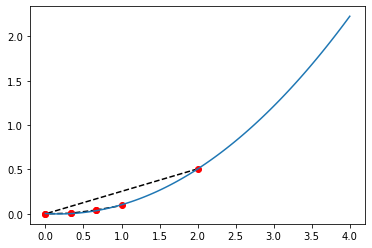

[ 0.15237017 -0.05400595  0.0037378 ]
V
Reference oxide formation energy: -2.501 eV
Reference oxide formation energy: -2.501 eV
{4.333: -2.3949, 6.0: -1.6536, 8.0: -1.1145, 5.0: -2.2453, 4.667: -2.279}


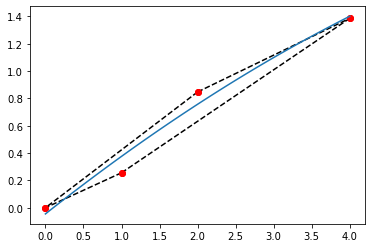

[-0.01980909  0.44094909 -0.04503818]
Reference oxide formation energy: -2.501 eV
{2.0: -2.2628, 3.0: -2.6305, 2.667: -2.3259, 3.333: -2.5769, 3.5: -2.5462, 3.6: -2.5527}


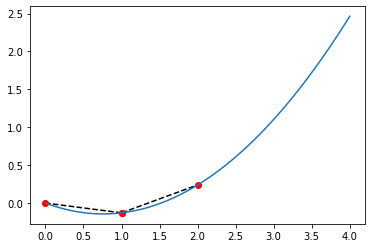

[ 2.48450000e-01 -3.77650000e-01  6.40987562e-17]
Cr
Reference oxide formation energy: -2.114 eV
Reference oxide formation energy: -2.114 eV
{6.0: -1.2393, 8.0: -0.5688}
Unsure what to do for: Cr


<ipython-input-5-f543129e29d0>:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


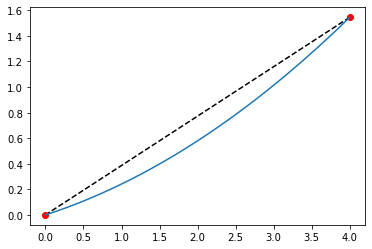

Reference oxide formation energy: -2.114 eV
{2.0: -1.9346, 3.0: -2.4859}


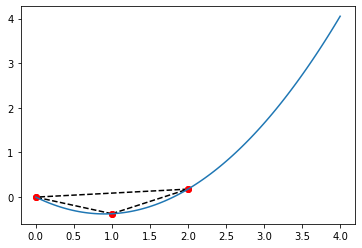

[ 4.61700000e-01 -8.33800000e-01  2.56395025e-16]
Mn
Reference oxide formation energy: -1.712 eV
Reference oxide formation energy: -1.712 eV
{6.0: -0.9015, 8.0: -0.9404, 5.0: -1.1189, 4.8: -1.301}
Unsure what to do for: Mn


<ipython-input-5-f543129e29d0>:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


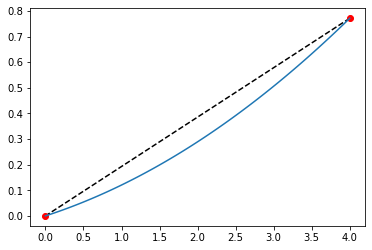

Reference oxide formation energy: -1.712 eV
{2.0: -2.0381, 3.0: -2.0173, 2.667: -2.0269, 3.2: -1.9504, 2.286: -2.0159}


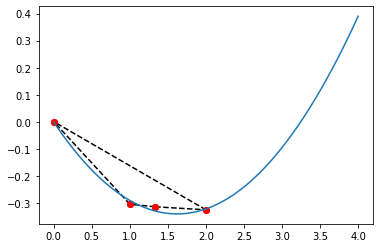

[ 0.12923186 -0.41891373 -0.00173419]
Fe
Reference oxide formation energy: -1.304 eV
Reference oxide formation energy: -1.304 eV
{6.0: -0.824, 8.0: -0.6932}
Unsure what to do for: Fe


<ipython-input-5-f543129e29d0>:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


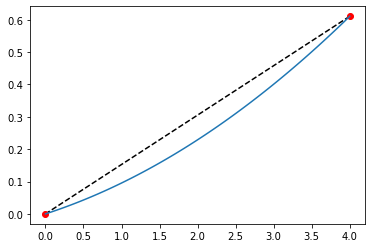

Reference oxide formation energy: -1.304 eV
{2.0: -1.543, 3.0: -1.6498, 2.667: -1.5733}


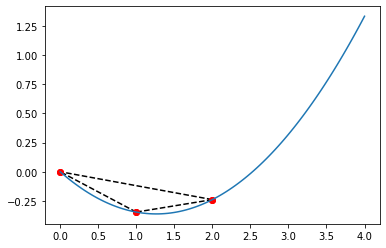

[ 2.26250000e-01 -5.71950000e-01  1.92296269e-16]
Co
Reference oxide formation energy: -0.991 eV
Reference oxide formation energy: -0.991 eV
{6.0: -0.357, 8.0: -0.6017}
Unsure what to do for: Co


<ipython-input-5-f543129e29d0>:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


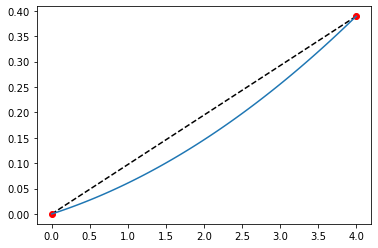

Reference oxide formation energy: -0.991 eV
{2.0: -1.2268, 3.0: -1.1568}


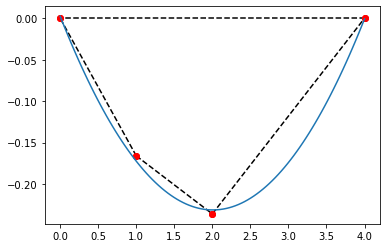

[ 0.058  -0.2328  0.0024]
Ni
Reference oxide formation energy: -0.482 eV
Reference oxide formation energy: -0.482 eV
{6.0: 0.057, 8.0: -0.5183}
Unsure what to do for: Ni


<ipython-input-5-f543129e29d0>:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


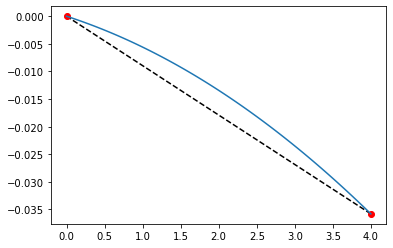

Reference oxide formation energy: -0.482 eV
{2.0: -1.2415, 3.0: -0.9035}


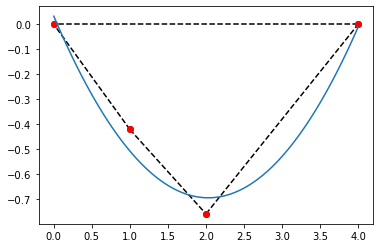

[ 0.17627273 -0.71587273  0.03234545]
Nb
Reference oxide formation energy: -2.692 eV
Reference oxide formation energy: -2.692 eV
{8.0: -1.4738, 5.0: -2.8355}


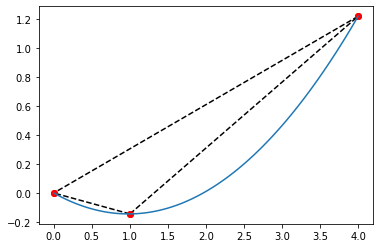

[ 1.49475000e-01 -2.93475000e-01 -3.20493781e-16]
Reference oxide formation energy: -2.692 eV
{2.0: -1.6987, 3.0: -2.332}


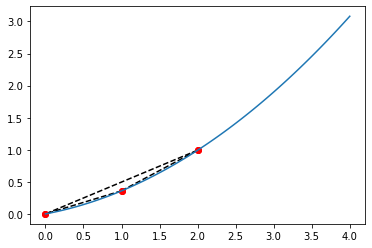

[ 1.36900000e-01  2.22600000e-01 -6.40987562e-17]
Mo
Reference oxide formation energy: -2.099 eV
Reference oxide formation energy: -2.099 eV
{6.0: -2.163, 8.0: -1.2532, 5.0: -2.151}


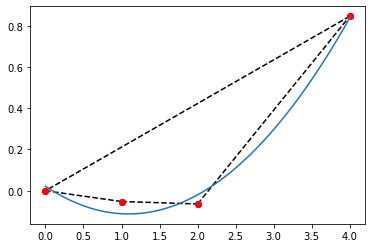

[ 0.11249318 -0.24594318  0.02218636]
Reference oxide formation energy: -2.099 eV
{2.0: -0.9259, 3.0: -1.8977}


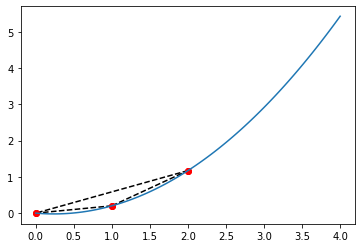

[ 3.85300000e-01 -1.84100000e-01  4.80740672e-17]
Tc
Reference oxide formation energy: -1.651 eV
Reference oxide formation energy: -1.651 eV
{6.0: -1.5168, 8.0: -1.1574}


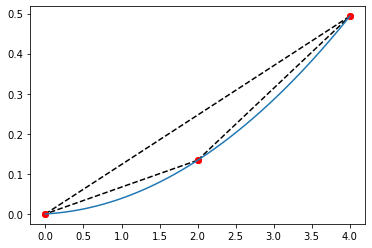

[2.81875000e-02 1.05750000e-02 2.80432058e-17]
Reference oxide formation energy: -1.651 eV
{2.0: -0.4771}
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 564649366  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

 needs to be done differently.
not much info ...
Ru
Reference oxide formation energy: -1.268 eV
Reference oxide formation energy: -1.268 eV
{6.0: -0.9614, 8.0: -0.3797, 5.0: -1.0829}


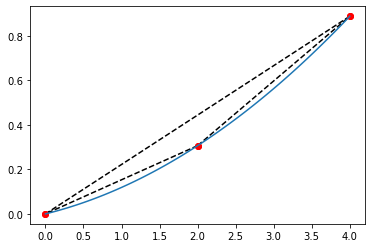

[ 3.43625000e-02  8.46750000e-02 -4.80740672e-17]
Reference oxide formation energy: -1.268 eV
{2.0: -0.1658, 3.0: -0.9507}


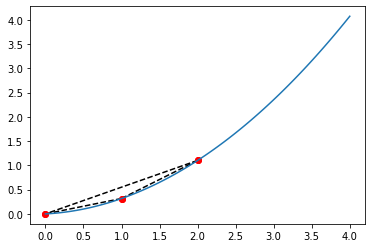

[ 2.33700000e-01  8.38000000e-02 -1.36209857e-16]
Rh
Reference oxide formation energy: -1.040 eV
Reference oxide formation energy: -1.040 eV
{6.0: -0.5166, 8.0: -0.5631}
Unsure what to do for: Rh


<ipython-input-5-f543129e29d0>:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


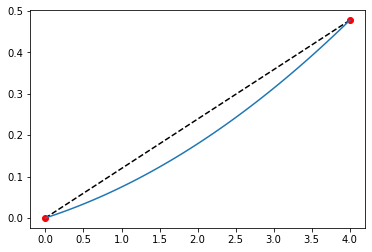

Reference oxide formation energy: -1.040 eV
{2.0: -0.1427, 3.0: -0.9171}


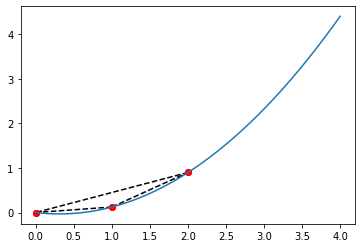

[ 3.25550000e-01 -2.02250000e-01  6.40987562e-17]
Pd
Reference oxide formation energy: -0.542 eV
Reference oxide formation energy: -0.542 eV
{6.0: -0.3234, 8.0: -0.3845, 5.0: -0.3114}
Unsure what to do for: Pd


<ipython-input-5-f543129e29d0>:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


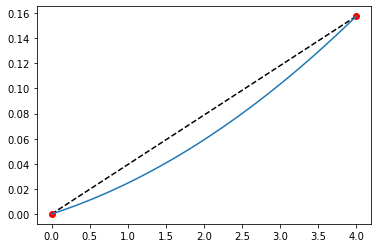

Reference oxide formation energy: -0.542 eV
{2.0: -0.204, 3.0: -0.5308}


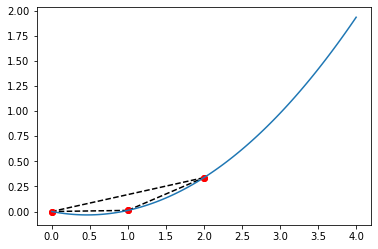

[ 1.57750000e-01 -1.46450000e-01  4.80740672e-17]
Sn
Reference oxide formation energy: -1.954 eV
Reference oxide formation energy: -1.954 eV
{5.5: -1.2297, 6.0: -1.1579, 5.0: -1.2146, 12.0: 0.3258}


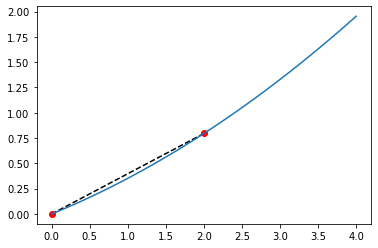

[ 4.52875000e-02  3.07225000e-01 -3.20493781e-16]
Reference oxide formation energy: -1.954 eV
{}
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 564817436  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

 needs to be done differently.
not much info ...
Sb
Reference oxide formation energy: -1.484 eV
Reference oxide formation energy: -1.484 eV
{5.0: -1.5501}


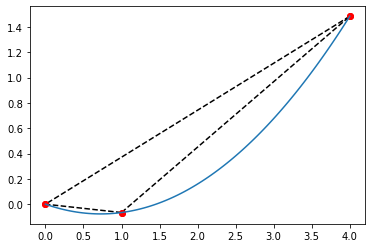

[ 1.45675000e-01 -2.11675000e-01 -2.24345647e-16]
Reference oxide formation energy: -1.484 eV
{3.0: -1.2774}
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 564851050  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

 needs to be done differently.
not much info ...
Te
Reference oxide formation energy: -1.079 eV
Reference oxide formation energy: -1.079 eV
{6.0: -1.1054}


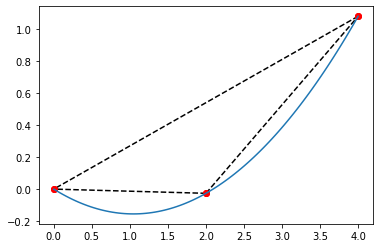

[ 1.41462500e-01 -2.96075000e-01  3.20493781e-16]
Reference oxide formation energy: -1.079 eV
{}
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 564901471  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

 needs to be done differently.
not much info ...
Ta
Reference oxide formation energy: -2.856 eV
Reference oxide formation energy: -2.856 eV
{8.0: -1.865, 5.0: -3.1436}


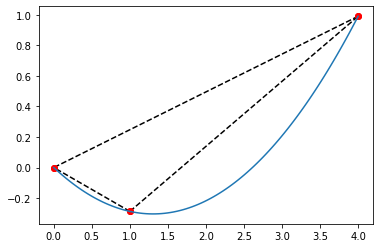

[ 1.78375000e-01 -4.65675000e-01 -2.56395025e-16]
Reference oxide formation energy: -2.856 eV
{2.0: -1.5884, 3.0: -2.3265}


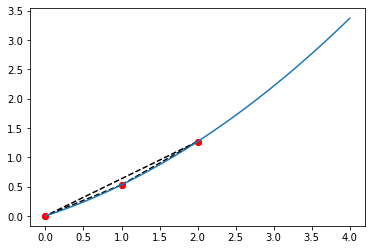

[ 1.04150000e-01  4.25650000e-01 -1.92296269e-16]
W
Reference oxide formation energy: -2.120 eV
Reference oxide formation energy: -2.120 eV
{6.0: -2.4458, 8.0: -1.5927}


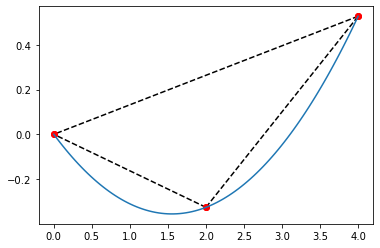

[ 1.47387500e-01 -4.57775000e-01  6.40987562e-16]
Reference oxide formation energy: -2.120 eV
{2.0: -0.5625, 3.0: -1.7421}


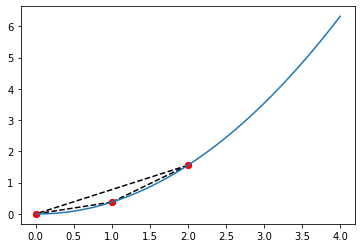

[ 4.00950000e-01 -2.32500000e-02  9.61481343e-17]
Re
Reference oxide formation energy: -1.587 eV
Reference oxide formation energy: -1.587 eV
{6.0: -1.9047, 8.0: -1.3721, 5.0: -1.7584}


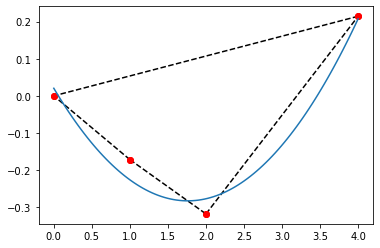

[ 0.09782955 -0.34449955  0.02041909]
Reference oxide formation energy: -1.587 eV
{2.0: -0.0688}
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565002313  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

 needs to be done differently.
not much info ...
Os
Reference oxide formation energy: -1.161 eV
Reference oxide formation energy: -1.161 eV
{6.0: -1.2007, 8.0: -1.1059, 5.0: -1.1885}


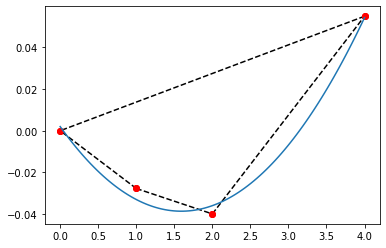

[ 0.01601136 -0.05098136  0.00198273]
Reference oxide formation energy: -1.161 eV
{2.0: 0.3447, 3.0: -0.5167}


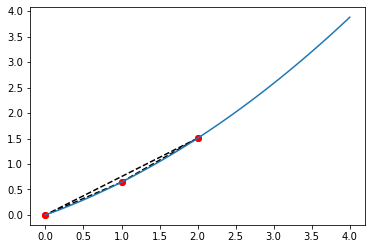

[ 1.08650000e-01  5.35450000e-01 -1.92296269e-16]
Ir
Reference oxide formation energy: -1.064 eV
Reference oxide formation energy: -1.064 eV
{6.0: -0.8429, 8.0: -0.6093, 5.0: -0.7744}


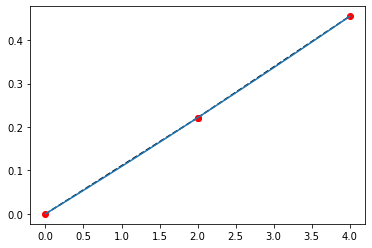

[ 1.52500000e-03  1.07650000e-01 -1.60246891e-16]
Reference oxide formation energy: -1.064 eV
{2.0: 0.3099, 3.0: -0.5545}


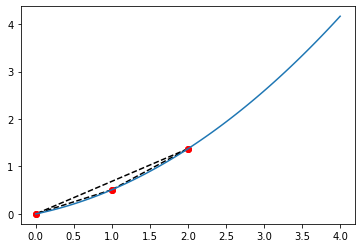

[ 1.77300000e-01  3.32500000e-01 -3.20493781e-17]
Pt
Reference oxide formation energy: -0.700 eV
Reference oxide formation energy: -0.700 eV
{6.0: -0.3524, 8.0: -0.1037}
Unsure what to do for: Pt


<ipython-input-5-f543129e29d0>:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


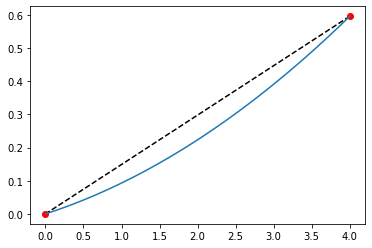

Reference oxide formation energy: -0.700 eV
{2.0: 0.2978}
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565086348  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

 needs to be done differently.
not much info ...
Tl
Reference oxide formation energy: -0.392 eV
Reference oxide formation energy: -0.392 eV
{6.0: 0.5283}
Unsure what to do for: Tl


<ipython-input-5-f543129e29d0>:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


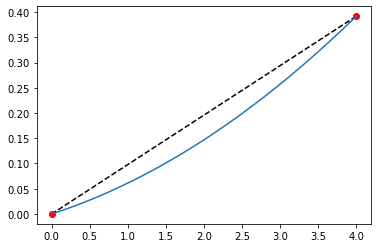

Reference oxide formation energy: -0.392 eV
{3.0: -0.9373}
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565103155  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

 needs to be done differently.
not much info ...
Ti
Reference oxide formation energy: -3.216 eV
Reference oxide formation energy: -3.216 eV
{5.5: -2.3594, 4.8: -2.4729, 6.0: -2.0049, 8.0: -1.4629, 5.0: -2.643}


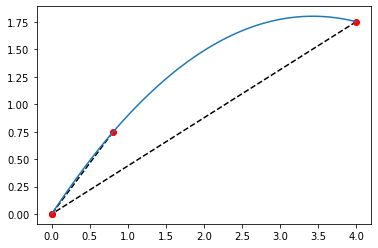

[-1.53250000e-01  1.05122500e+00  2.56395025e-16]
Reference oxide formation energy: -3.216 eV
{2.0: -2.7094, 3.667: -3.2091, 3.714: -3.2068, 3.0: -3.1219, 3.333: -3.1736, 2.5: -2.9429, 3.5: -3.189, 3.6: -3.1993}


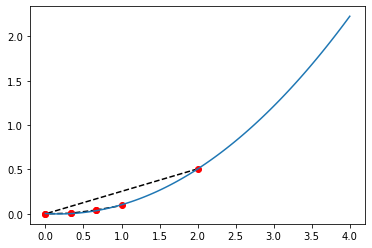

[ 0.15237017 -0.05400595  0.0037378 ]
Nb
Reference oxide formation energy: -2.692 eV
Reference oxide formation energy: -2.692 eV
{8.0: -1.4738, 5.0: -2.8355}


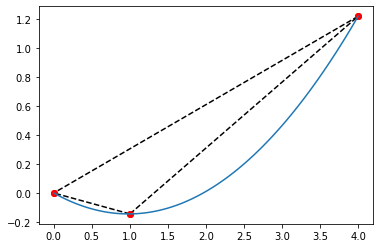

[ 1.49475000e-01 -2.93475000e-01 -3.20493781e-16]
Reference oxide formation energy: -2.692 eV
{2.0: -1.6987, 3.0: -2.332}


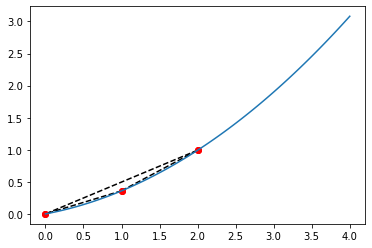

[ 1.36900000e-01  2.22600000e-01 -6.40987562e-17]
Pb
Reference oxide formation energy: -1.115 eV
Reference oxide formation energy: -1.115 eV
{6.0: -0.6135, 5.0: -0.4382}


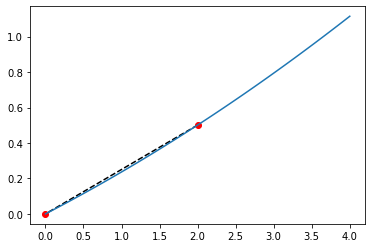

[ 1.40500000e-02  2.22450000e-01 -1.92296269e-16]
Reference oxide formation energy: -1.115 eV
{}
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565254418  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

 needs to be done differently.
not much info ...
Bi
Reference oxide formation energy: -1.285 eV
Reference oxide formation energy: -1.285 eV
{6.0: -0.1187}
Unsure what to do for: Bi


<ipython-input-5-f543129e29d0>:81: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


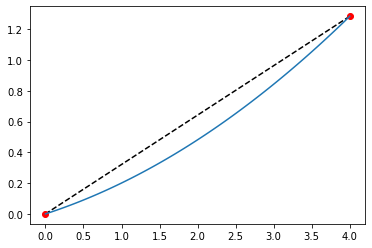

Reference oxide formation energy: -1.285 eV
{3.0: -1.4412}
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565304839  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

 needs to be done differently.
not much info ...


In [5]:
elements2consider = ['Ga', 'Si', 'Ge', 'Se'
    'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 
    'Cu', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Sn', 'Sb', 'Te',
    'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt'
                     ]

elements2consider = [ 'Ge', 'Se',
    'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 
     'Nb', 'Mo', 'Tc',
    
    'Ru', 'Rh', 'Pd', 'Sn', 'Sb', 'Te',
    'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Tl', 'Ti', 'Nb', 'Pb',
    'Bi',
    #'Si',
                     ]

directory_path = "../data_gather/oqmd_data"
ref_oxidation_state = 4
quadratic_equations_ox = defaultdict()
quadratic_equations_red = defaultdict()
for ele in elements2consider:
    oqmd_info = pandas.read_csv("{}/target_props/target_properties_{}o2.csv".format(directory_path, ele))
    print(ele)
    oqmd_enes = defaultdict()
    #print(oqmd_info)
    spg_match_data = get_entry_by_spacegroup(oqmd_info, "P42/mnm")
    if ele=='Bi':
        spg_match_data = get_entry_by_spacegroup(oqmd_info, "C2/c")
    matching_ids = []
    for match in spg_match_data:
        matching_ids.append(match.split("En")[1].split(".")[0])
    #print(spg_match_data)
    #continue
    oqmd_ids = []
    for name, energy in zip(oqmd_info['filename'], oqmd_info[' _oqmd_delta_e']):
        #print(energy, name)
        oqmd_id = name.split("En")[1].split('.')[0]
        oqmd_enes[oqmd_id] = energy
        #oqmd_enes[poscar.split("_")[0]] = oqmd_info[' _oqmd_delta_e'][idx]
        oqmd_ids.append(oqmd_id)

    poscars = os.popen("ls {}/input_poscars/input_poscars_{}o2".format(directory_path, ele)).readlines()
    poscars = [x.strip("\n") for x in poscars]
    oqmd_structs = defaultdict()
    for poscar in poscars:
        struct = io.read("{}/input_poscars/input_poscars_{}o2/{}".format(directory_path, ele, poscar))
        pymat_struct = AseAtomsAdaptor.get_structure(struct)
        oqmd_structs[poscar.split("En")[1].split('.')[0]] = pymat_struct
        
    # need to find the reference id
    reference_found = False
    for match in matching_ids:
        cords, oxi_state, o_o_coords, _, _ = structure_inspection(oqmd_structs[match])
        #print(data)
        if oxi_state==ref_oxidation_state:
            reference_id = match
            reference_found = True
            
    assert reference_found
    #continue
    
    #for ele in ['Sn']:
    #print(ele)
    ref_ene = get_ref_data_oqmd(ele, reference_id)

    ox2low = get_ox2lowest_oqmd(ele, reference_id, oxidising=True)
    hull_ox2energy = get_lower_hull_oqmd(ox2low, 4,ref_ene, ele, oxidising=True)
    
        
    #print(list(hull_ox2energy.keys())
    if hull_ox2energy is not None:
        other_oxes = list(hull_ox2energy.keys())

    if len(other_oxes)==2 and 4.0 not in other_oxes and hull_ox2energy is not None:
        hull_ox2energy[4.0] = -ref_ene
        coeffs = get_quadratic(hull_ox2energy)
        quadratic_equations_ox[ele] = coeffs
        print(coeffs)
    elif len(other_oxes)==2 and hull_ox2energy is not None:
        print("Unsure what to do for: {}".format(ele))
        coeffs = get_quadratic(hull_ox2energy)
        quadratic_equations_ox[ele] = [0, -ref_ene/4,0]
    elif hull_ox2energy is not None:
        coeffs = get_quadratic(hull_ox2energy)
        quadratic_equations_ox[ele] = coeffs
        print(coeffs)
    else:
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        print("not much info ...")
        quadratic_equations_ox[ele] = [0, -ref_ene/4,0]
    plt.show()
    
    ox2low = get_ox2lowest_oqmd(ele, reference_id, oxidising=False)
    hull_ox2energy = get_lower_hull_oqmd(ox2low, 4,ref_ene, ele, oxidising=False)
    
    if hull_ox2energy is None:
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        quadratic_equations_red[ele] = [0, -ref_ene/4,0]
        
    if hull_ox2energy is not None:
        other_oxes = list(hull_ox2energy.keys())

    if len(other_oxes)==2 and 4.0 not in other_oxes and hull_ox2energy is not None:
        hull_ox2energy[4.0] = -ref_ene
        coeffs = get_quadratic(hull_ox2energy)
        quadratic_equations_red[ele] = coeffs
        print(coeffs)
    elif len(other_oxes)==2 and hull_ox2energy is not None:
        print("Unsure what to do for: {}".format(ele))
        coeffs = get_quadratic(hull_ox2energy)
        quadratic_equations_red[ele] = [0, -ref_ene/4,0]
    elif hull_ox2energy is not None:
        coeffs = get_quadratic(hull_ox2energy)
        quadratic_equations_red[ele] = coeffs
        print(coeffs)
    else:
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        print("not much info ...")
        quadratic_equations_red[ele] = [0, -ref_ene/4,0]

    
    

In [6]:
pickle.dump(quadratic_equations_ox, open("oqmd_quadratic_equations_ox.p", "wb"))
pickle.dump(quadratic_equations_red, open("oqmd_quadratic_equations_red.p", "wb"))


Mo


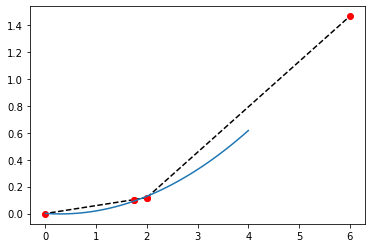

W


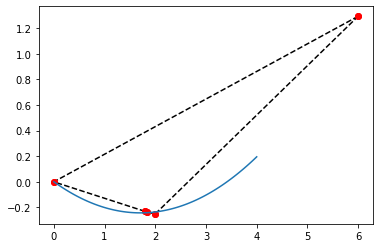

Nb


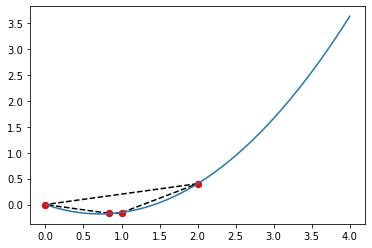

Ni


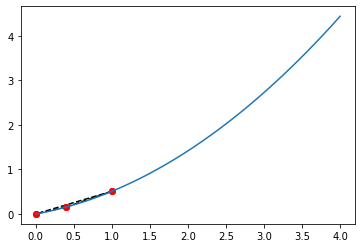

V


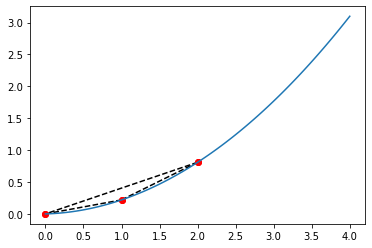

Ir
WARNING! Adding an end member so can perform fit, try gather more data for this element.


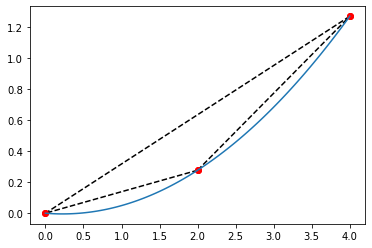

Ru
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565422488  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ru needs to be done differently.
Cr


<ipython-input-7-9f1d30ee829b>:49: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


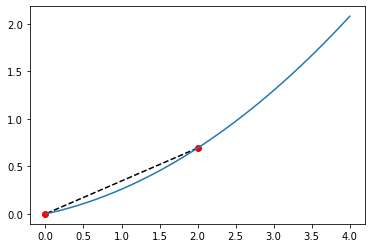

Fe


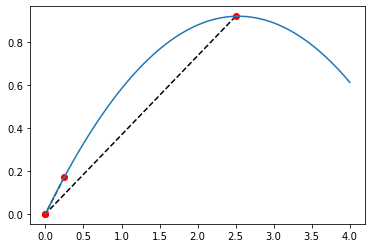

Mn


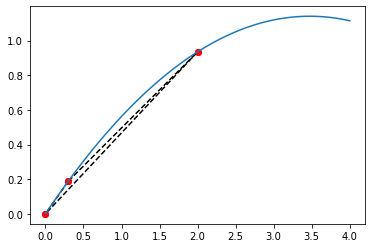

Co
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565489716  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Co needs to be done differently.
Pb
WARNING! Adding an end member so can perform fit, try gather more data for this element.


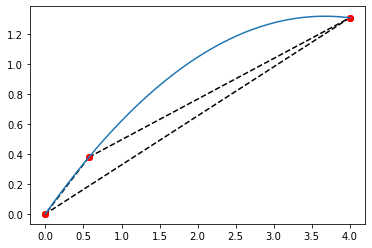

Sb


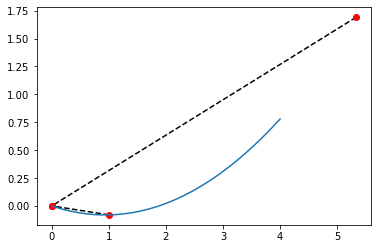

Sn
WARNING! Adding an end member so can perform fit, try gather more data for this element.


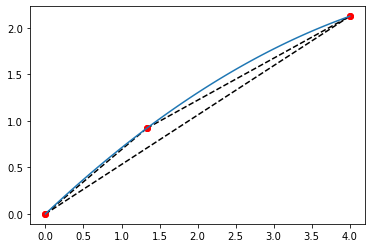

Bi


<ipython-input-7-9f1d30ee829b>:49: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


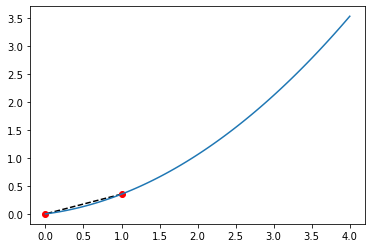

Ti


<ipython-input-7-9f1d30ee829b>:49: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


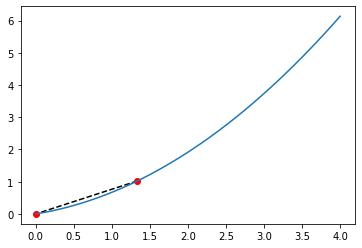

Ta


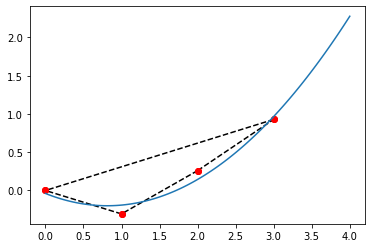

In
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565556944  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

In needs to be done differently.
Pt


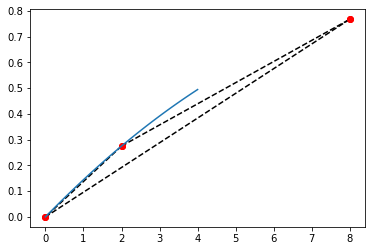

Pd
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565556944  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Pd needs to be done differently.
Re


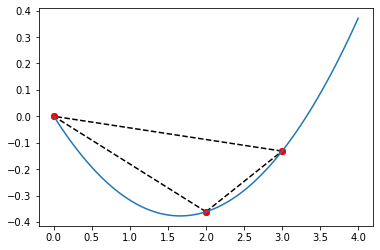

Os
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565556944  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Os needs to be done differently.
Ge
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565556944  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ge needs to be done differently.
Tc
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565556944  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Tc needs to be done differently.
Rh
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options se

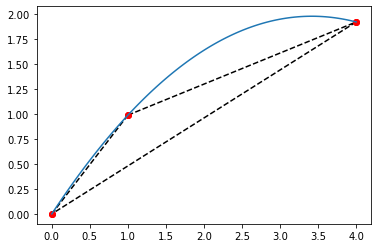

Nb
2.0
3.0


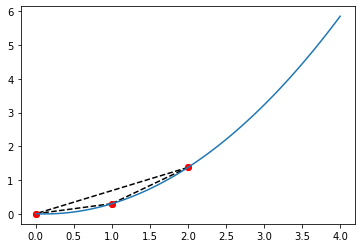

Ni
2.4
2.333
2.889
2.133
3.0
2.222
2.0
2.667
2.8


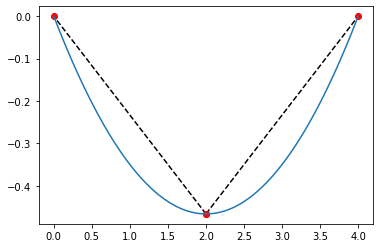

V
3.6
2.0
3.778
3.333
3.0
3.714
3.667
3.75
3.5


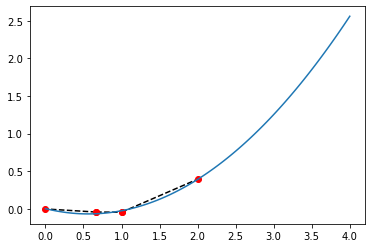

Ir
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565657786  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ir  needs to be done differently.
Ru
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565657786  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ru  needs to be done differently.
Cr
2.0
3.0
3.667


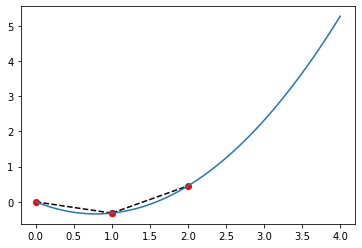

Fe
2.143
2.286
2.25
3.0
2.2
2.0
2.222
2.5
2.667
2.118
2.154
2.053
2.057
2.174
2.19
2.187
2.308
2.182
2.167


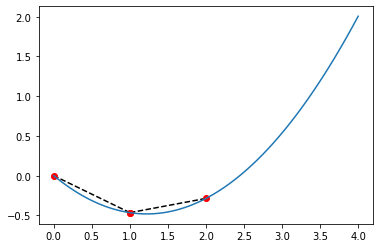

Mn
3.0
3.2
2.0
2.667


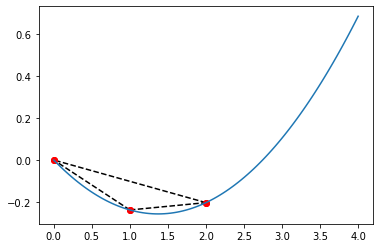

Co
2.0
3.0
3.429
3.733


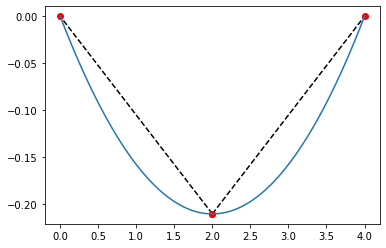

Pb
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565725014  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Pb  needs to be done differently.
Sb
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565741821  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Sb  needs to be done differently.
Sn
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565741821  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Sn  needs to be done differently.
Bi
3.0
WARNING! Adding an end member so can perform fit, try gather more data for this element.


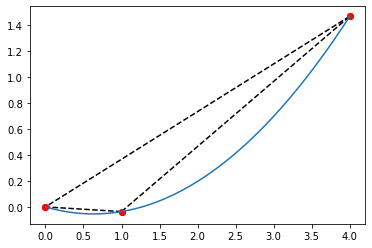

Ti
3.75
3.0
2.0
2.667
2.6
3.714
3.273
3.2
2.2
2.545
3.333
2.5
3.778
3.385
3.667
3.5
3.158
3.6
3.25


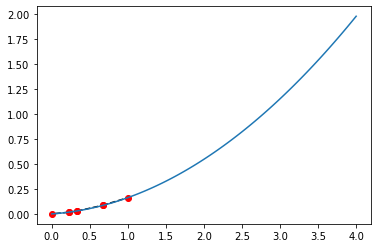

Ta
3.0
2.0


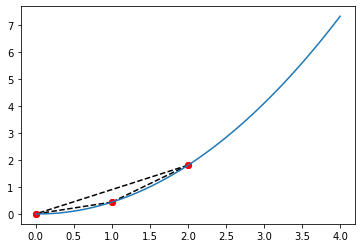

In
3.0
WARNING! Adding an end member so can perform fit, try gather more data for this element.


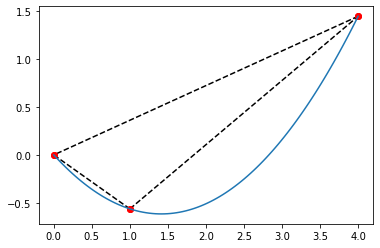

Pt
2.0
WARNING! Adding an end member so can perform fit, try gather more data for this element.


<ipython-input-7-9f1d30ee829b>:65: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


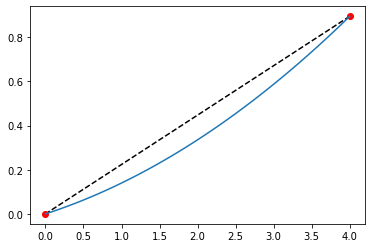

Pd
2.0
WARNING! Adding an end member so can perform fit, try gather more data for this element.


<ipython-input-7-9f1d30ee829b>:65: RankWarning: Polyfit may be poorly conditioned
  coeffs = get_quadratic(hull_ox2energy)


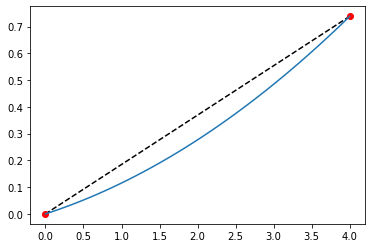

Re
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565792242  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Re  needs to be done differently.
Os
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565792242  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Os  needs to be done differently.
Ge
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 565792242  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Ge  needs to be done differently.
Tc
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options

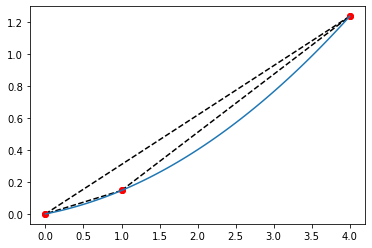

In [7]:
ox_state = 4

# define your reference materials project ids you want to compare, for now taking rutile if exists, or lowest
# octahedral MO2.
ele2mp = {
    'Mo': 'mp-510536',
    'W': 'mp-19372',
    'Nb': 'mp-2533',
    'Ni': 'mp-35925', # layered Ni
    'V': 'mp-19094',
    'Ir': 'mp-2723',
    'Ru': 'mp-825',
    'Cr': 'mp-19177',
    'Fe': 'mp-850222',
    'Mn': 'mp-510408',
    'Co': 'mp-1272749', # layered Co 
    'Pb': 'mp-20725',
    'Sb': 'mvc-9819', # mvc-9819 chosen since it is 0.17 eV/atom more unstable than the most stable MP SbO2 (this is chosen because OQMD has this difference for its rutile SbO2)
    'Sn': 'mp-856',
    'Bi': 'mp-557993',
    'Ti': 'mp-2657',
    'Ta': 'mp-20994',
    'In': 'mp-1181008',
    'Pt': 'mp-1077716',
    'Pd': 'mp-1018886',
    'Re': 'mp-12875',
    'Os': 'mp-996',
    'Ge': 'mp-2633',# not rutile
    'Tc': 'mp-1205302',
    'Rh': 'mp-725',
}

mp_quadratic_equations_ox = defaultdict()
for ele in ele2mp:
    print(ele)
    # TO DO: Read in all the data for each element once
    #if ele=='Sb':
    #    form_ene += 0.15

    ox2low, form_ene = get_ox2lowest(ele, ele2mp[ele], ox_state, oxidising=True)
    hull_ox2energy = get_lower_hull(ox2low, ox_state, form_ene, ele, oxidising=True)
    if hull_ox2energy is None:
        ref_ene, _, _ = get_ref_data(ele, ele2mp[ele])
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        quadratic_equations_ox[ele] = [0, -ref_ene/4,0]
        continue
        
    coeffs = get_quadratic(hull_ox2energy)
    mp_quadratic_equations_ox[ele] = coeffs
    
mp_quadratic_equations_red = defaultdict()
for ele in ele2mp:
    print(ele)
    ox2low, form_ene = get_ox2lowest(ele, ele2mp[ele], ox_state, oxidising=False)
        
    hull_ox2energy = get_lower_hull(ox2low, ox_state, form_ene, ele, oxidising=False)
    if hull_ox2energy is None:
        ref_ene, _, _ = get_ref_data(ele, ele2mp[ele])
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        quadratic_equations_red[ele] = [0, -form_ene/4, 0]
        continue
    
    coeffs = get_quadratic(hull_ox2energy)
    mp_quadratic_equations_red[ele] = coeffs

In [8]:
pickle.dump(mp_quadratic_equations_ox, open("mp_quadratic_equations_ox.p", "wb"))
pickle.dump(mp_quadratic_equations_red, open("mp_quadratic_equations_red.p", "wb"))
